In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

from matplotlib import cm
from numpy import arctan, log, pi, sqrt

%matplotlib notebook


os.chdir("D:\Engineering\Python\FHD")

In [2]:
#Making grid

nx  = 50
ny  = 50
nt  = 100

xmin = 0
xmax = 10
ymin = 0
ymax = 10

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 0.01

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

X, Y = np.meshgrid(x, y)

In [3]:
u  = np.zeros((nx, ny))
un = np.zeros((nx, ny))

v  = np.zeros((nx, ny))
vn = np.zeros((nx, ny))

T  = np.zeros((nx, ny))
Tn = np.zeros((nx, ny))

C  = np.zeros((nx, ny))
Cn = np.zeros((nx, ny))

In [4]:
#Problem specs

a = 1
beta = 2   #21e5
nu = 1.0546875e-06
gamma = 1
n1 = 0.6  #power on the paranthesis "n"
rho = 1024
mu0 = 4e-7*pi
M = 8.6e5
h = 12.5e-6   #height of magnet
w = 25e-6     #width of magnet
c = 4179      #spcefic heat
kinf = 0.613
eps = 0.2
tau = 2
Q0 = 50 #heat generation
DB = 1
DT = 1

#Boundary Condition

V0 = 10
# Uw = 5
# Vw = -10
hf = 1
Tf = 250
hm = 1
Cf = 20
Cinf = 100
delT = 100
Tinf = 373.15

In [5]:
def Hcalc(M, i, j, h, w):
    H = M**2*(-4*h*((4*h**2*(w - i)**2 + (-h**2 + j**2 + (w - i)**2)**2)*(-h**2 + j**2 - (w + i)**2) + (4*h**2*(w + i)**2 + (-h**2 + j**2 + (w + i)**2)**2)*(h**2 - j**2 + (w - i)**2))*((-h + j)**2 + (-w + i)**2)*((-h + j)**2 + (w + i)**2)*((h + j)**2 + (-w + i)**2)*((h + j)**2 + (w + i)**2)*(arctan(2*h*(-w + i)/(-h**2 + j**2 + (-w + i)**2)) - arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2))) + (4*h**2*(w - i)**2 + (-h**2 + j**2 + (w - i)**2)**2)*(4*h**2*(w + i)**2 + (-h**2 + j**2 + (w + i)**2)**2)*(-(w + i)*(-(-h + j)**2 + (h + j)**2)*((-h + j)**2 + (-w + i)**2)*((h + j)**2 + (-w + i)**2) + ((-w + i)*((h + j)**2 + (-w + i)**2) + (w - i)*((-h + j)**2 + (-w + i)**2))*((-h + j)**2 + (w + i)**2)*((h + j)**2 + (w + i)**2))*(log(((-h + j)**2 + (-w + i)**2)/((h + j)**2 + (-w + i)**2)) - log(((-h + j)**2 + (w + i)**2)/((h + j)**2 + (w + i)**2))))/(2*pi*sqrt(M**2*((log(((h - j)**2 + (w - i)**2)/((h + j)**2 + (w - i)**2)) - log(((h - j)**2 + (w + i)**2)/((h + j)**2 + (w + i)**2)))**2 + 4*(arctan(2*h*(w - i)/(-h**2 + j**2 + (w - i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2))*(4*h**2*(w - i)**2 + (-h**2 + j**2 + (w - i)**2)**2)*(4*h**2*(w + i)**2 + (-h**2 + j**2 + (w + i)**2)**2)*((-h + j)**2 + (-w + i)**2)*((-h + j)**2 + (w + i)**2)*((h + j)**2 + (-w + i)**2)*((h + j)**2 + (w + i)**2))
    return H

In [6]:
#Boundary conditions #1
T[:, 1] = -((hf*dy)/kinf) * (Tf - T[:, 0]) + T[:, 0]
C[:, 1] = -((hm*dy)/DB) * (Cf - C[:, 0]) + C[:, 0]
T[:, ny-1] = Tinf
C[:, ny-1] = Cinf
v[:, ny-1] = 0

In [7]:
#Boundary conditions #2

for n in range(nt):
    for i in range(nx):
        u[i, ny-1] = (a*i)/(1-beta*n)
        u[i, 0]    = (a*i)/ (1-(beta*n))
        v[i, 0]    = (-V0)/(1-(beta*n)**(0.5))

In [8]:
#Iteration

udiff = 1
Tdiff = 1
Cdiff = 1
stepcount = 0
accu = 0.001

udiffDat = []
TdiffDat = []
CdiffDat = []


while (udiff > accu) and (Tdiff > accu) and (Cdiff > accu):
    un = u.copy()
    vn = v.copy()
    Tn = T.copy()
    Cn = C.copy()

    for n in range(nt):
        for i in range(nx-2):
            for j in range(1, ny-2):
                #Velocity
                u[i, j] = dt * (((a*i*(a+beta))/(1-beta*n)**2) +
                                (nu * (un[i, j+1] - 2*un[i, j] + un[i, j-1])/(2*dy)) *
                                (1 + (gamma**2) *
                                (((un[i, j+1] - un[i, j])/dy)**2))**((n1-1)/2) +
                                nu*(n1-1) * (gamma**2) * ((un[i, j+1] - 2*un[i, j] + un[i, j-1])/(2*dy)) * 
                                (((un[i, j+1] - un[i, j])/dy)**2) *
                                (1 + (gamma**2)* 
                                ((un[i, j+1] - un[i, j])/dy)**2)**((n1-3)/2) +
                                mu0*M/rho * (M**2*(-4*h*((4*h**2*(w - i)**2 + Hcalc(M, i, j, h, w) - 
                                ((un[i, j] * (un[i+1, j] - un[i, j])/dx) +
                                 (vn[i, j] * (un[i, j+1] - un[i, j])/dy))) + un[i, j]))))

                #Temperature
                T[i, j] = dt * ((1/(rho*c)) * (kinf * ((Tn[i, j+1] - 2*Tn[i, j] + Tn[i, j-1])/(2*dy)) + 
                               (kinf*eps/delT)* Tn[i ,j] * ((Tn[i, j+1] - Tn[i, j])/dy) - 
                                ((kinf * eps)/delT)*Tinf * ((Tn[i, j+1] - Tn[i, j])/dy)) + 
                                tau * (DB * ((Cn[i, j+1] - Cn[i, j])/dy) * ((Tn[i, j+1] - Tn[i, j])/dy) + 
                                (DT/Tinf) * ((Tn[i, j+1] - Tn[i, j])/dy)**2) + 
                                (Q0/(rho*c)) * (Tn[i, j] - Tinf) - 
                                (un[i, j] * ((Tn[i+1, j] - Tn[i, j])/dx) +
                                 vn[i, j] * ((Tn[i, j+1] - Tn[i, j])/dy))) + Tn[i, j]

                #Concentration
                C[i, j] = dt * (DB * ((Cn[i, j+1] - 2*Cn[i, j] + Cn[i, j-1])/(2*dy)) + 
                                (DT/Tinf) * ((Tn[i, j+1] - 2*Tn[i, j] + Tn[i, j-1])/2*dy) -
                                (un[i, j] * ((Cn[i+1, j] - Cn[i, j])/dx) + 
                                 vn[i, j] * ((Cn[i, j+1] - Cn[i, j])/dy))) + Cn[i, j]




                udiff = (np.sum(u) - np.sum(un))/np.sum(u)
                Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
                Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)

                #print("udiff = " + str(udiff), "; Tdiff = " + str(Tdiff), " Cdiff = " + str(Cdiff))

                stepcount += 1

                print(stepcount)

                udiffDat.append(udiff)
                TdiffDat.append(Tdiff)
                CdiffDat.append(Cdiff)



                if (udiff > 0) or (Tdiff > 0) or (Cdiff > 0):
                    break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228
2229
2230
2231
2232
2233
2234
2235
2236
2237
2238


4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301
4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313
4314
4315
4316
4317
4318
4319
4320
4321
4322
4323
4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334
4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346
4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360
4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371
4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383
4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476


<IPython.core.display.Javascript object>


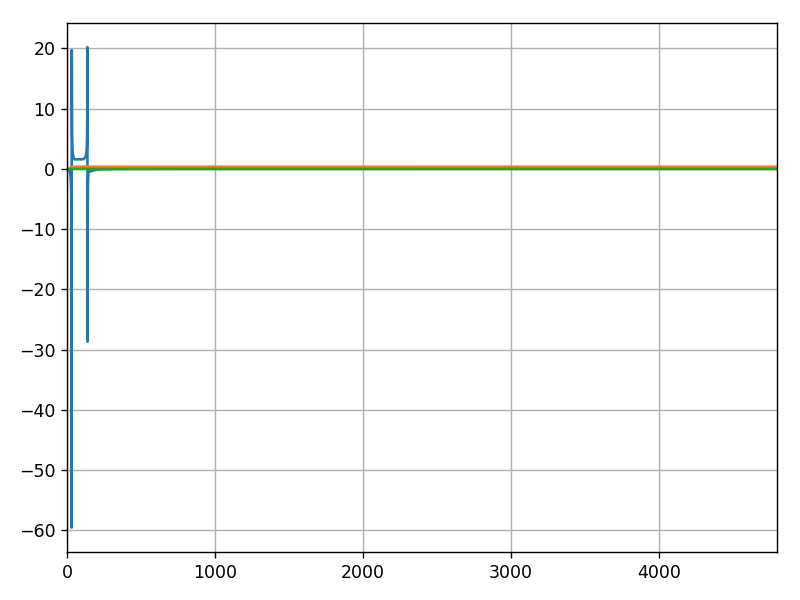

In [9]:
%matplotlib notebook

xu = np.linspace(0, stepcount, stepcount)

pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(xu, udiffDat)
pp.plot(xu, TdiffDat)
pp.plot(xu, CdiffDat)

pp.grid(True)
pp.tight_layout()

<IPython.core.display.Javascript object>


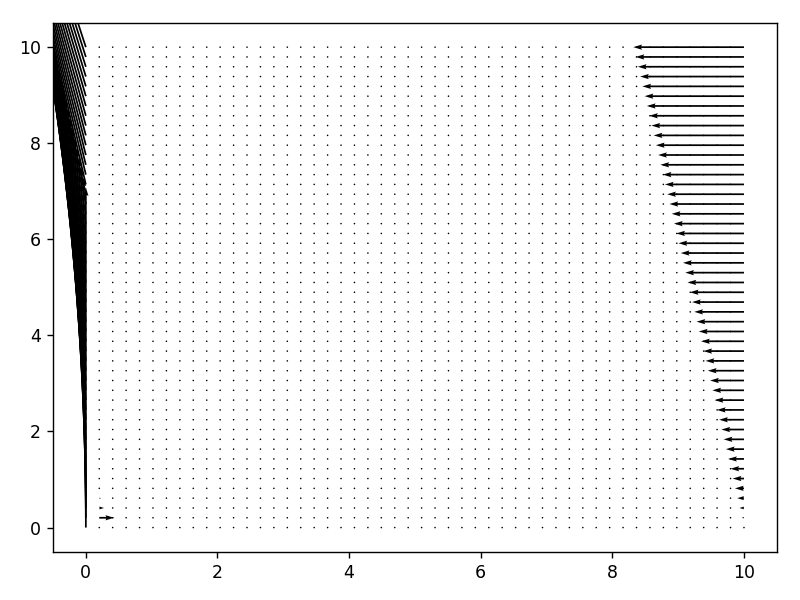

In [10]:
pp.figure()
pp.quiver(X, Y, u, v);
pp.tight_layout()

<IPython.core.display.Javascript object>


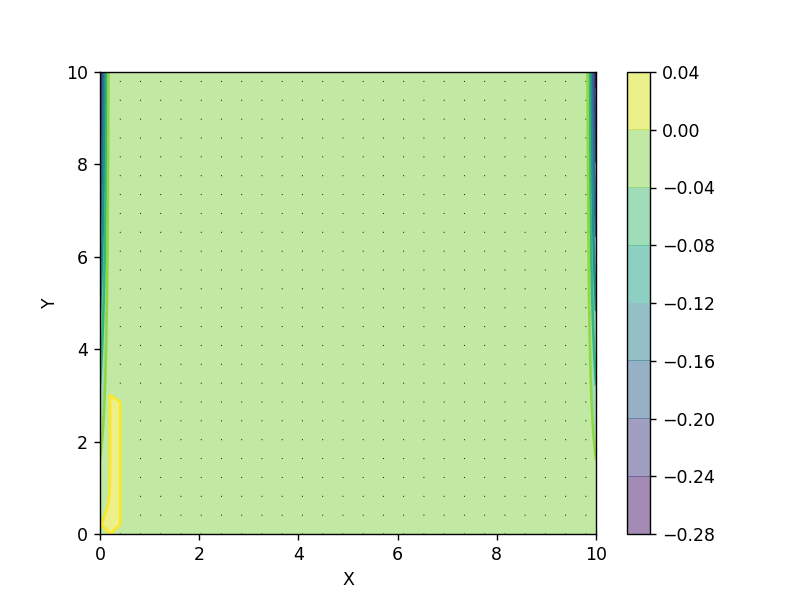

In [11]:
fig = pp.figure()
# plotting the pressure field as a contour
pp.contourf(X, Y, u, alpha=0.5, cmap=cm.viridis)  
pp.colorbar()
# plotting the pressure field outlines
pp.contour(X, Y, u, cmap=cm.viridis)  
# plotting velocity field
pp.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pp.xlabel('X')
pp.ylabel('Y');